In [1]:
ROOT = '/Users/longhoang/Developer/table-recognition/data/SciTSR-partition'

In [2]:
import os
import cv2 as cv
import numpy as np
import glob
import json
import matplotlib.pyplot as plt
from typing import List
import copy
from tqdm import tqdm

from data_utils.utils import *
from merge.heuristics import *
from evaluation.relation import Relation

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


### Loading Split ground truths

In [3]:
train_dir = os.path.join(ROOT, 'train')
val_dir = os.path.join(ROOT, 'val')

train_label_path = os.path.join(train_dir, 'label')
val_label_path = os.path.join(val_dir, 'label')

train_split_labels = load_json(os.path.join(train_label_path, 'split_label.json'))
val_split_labels = load_json(os.path.join(val_label_path, 'split_label.json'))

len(train_split_labels), len(val_split_labels)

(10000, 1971)

### Calculating the adjacency relation F1

We try to calculate on a single image first

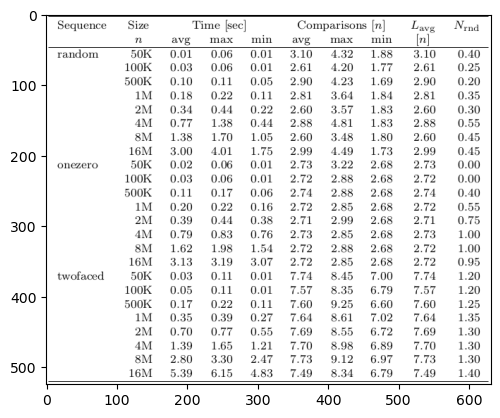

In [4]:
IDX = 68
img_names = list(train_split_labels.keys())
img_name = img_names[IDX]
# img_name = '1507.08539v1.1'
# img_name = '0801.1063v1.4'

img_path = os.path.join(train_dir, 'img', img_name + '.png')
img = load_image(img_path)
plt.imshow(img)

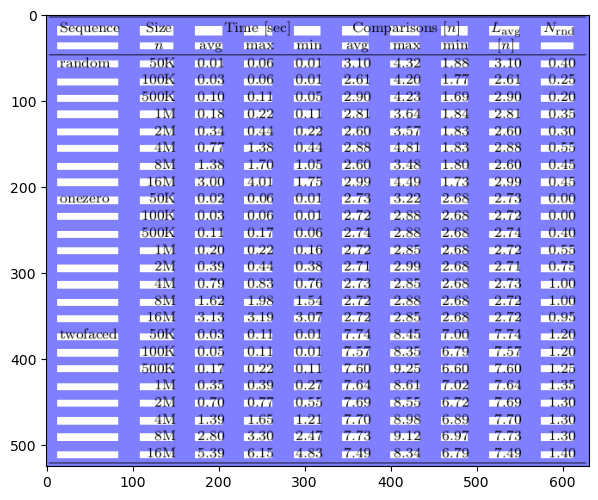

In [5]:
train_merge_labels = load_json(os.path.join(train_label_path, 'merge_label.json'))
val_merge_labels = load_json(os.path.join(val_label_path, 'merge_label.json'))

r_gt, c_gt, R_gt, D_gt = load_merge_gt(train_merge_labels, img_name)
vis_split(img, r_gt, c_gt);

In [6]:
row_gt_idxs, col_gt_idxs = borders(r_gt), borders(c_gt)
cells_gt = get_cells(row_gt_idxs, col_gt_idxs)

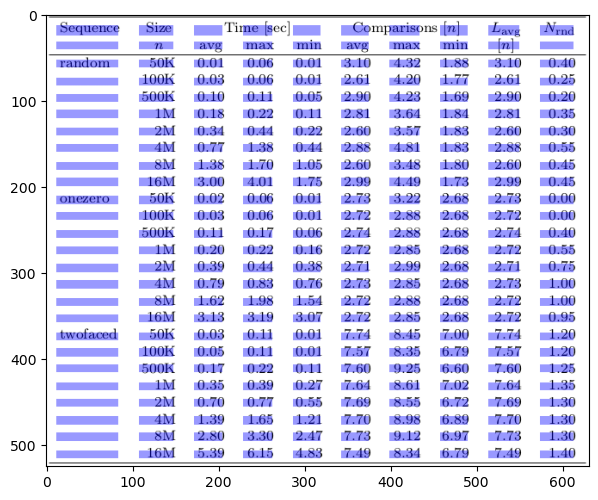

In [7]:
img_boxes = img.copy()
for cell in cells_gt:
    (t, l), (b, r) = cell.pos
    cv.rectangle(img_boxes, (l, t), (r, b), (0, 0, 255), -1)
res = cv.addWeighted(img_boxes, 0.4, img, 0.6, 0)

view_imgs([res])

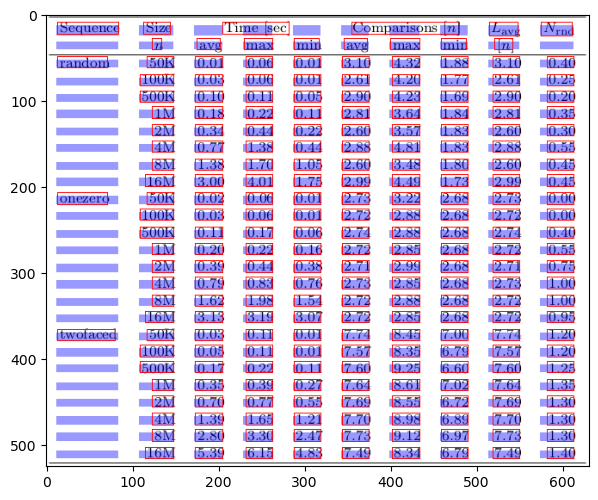

In [8]:
train_chunk_labels = load_json(os.path.join(train_label_path, 'chunk_label.json'))
val_chunk_labels  = load_json(os.path.join(val_label_path, 'chunk_label.json'))

img2 = res.copy()

for text, (l, t, r, b) in train_chunk_labels[img_name]:
    cv.rectangle(img2, (l, t), (r, b), (255, 0, 0), 1)

view_imgs([img2])

In [9]:
cells_merged_gt = merge_cells(cells_gt, R_gt, D_gt, verbose=True)

Merge right at cell (0,2)
Merge right at cell (0,3)
Merge right at cell (0,5)
Merge right at cell (0,6)


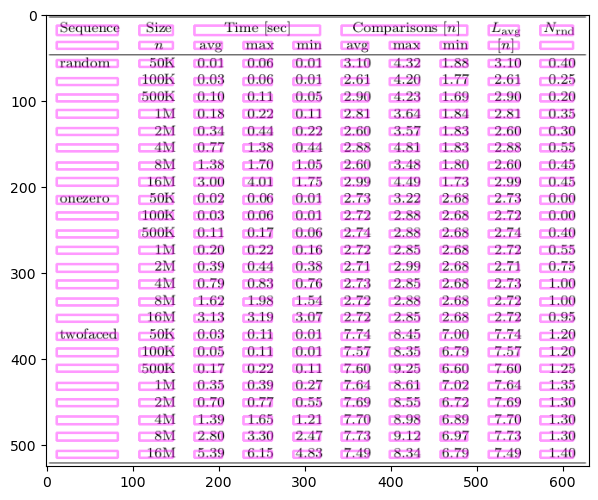

In [10]:
img_boxes = img.copy()
for cell in cells_merged_gt:
    (t, l), (b, r) = cell.pos
    cv.rectangle(img_boxes, (l, t), (r, b), (255, 0, 255), 2)
res = cv.addWeighted(img_boxes, 0.4, img, 0.6, 0)

view_imgs([res])

In [11]:
texts_pos = train_chunk_labels[img_name]
R_pred, D_pred = create_pred_matrices(row_gt_idxs, col_gt_idxs)
rule1(cells_gt, texts_pos, R_pred, D_pred)
rule2(cells_gt, texts_pos, R_pred, D_pred)
cells_merged_pred = merge_cells(cells_gt, R_pred, D_pred, verbose=True)

Merge right at cell (0,1)
Merge right at cell (0,3)
Merge right at cell (0,5)
Merge right at cell (0,6)


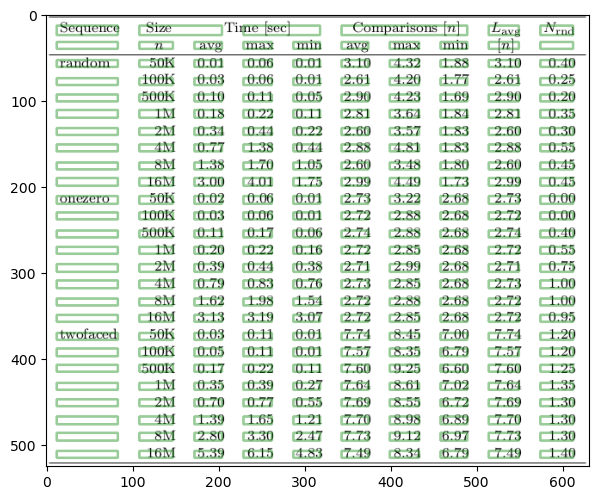

In [12]:
img_boxes = img.copy()
for cell in cells_merged_pred:
    (t, l), (b, r) = cell.pos
    cv.rectangle(img_boxes, (l, t), (r, b), (0, 127, 0), 2)
res = cv.addWeighted(img_boxes, 0.4, img, 0.6, 0)

view_imgs([res])

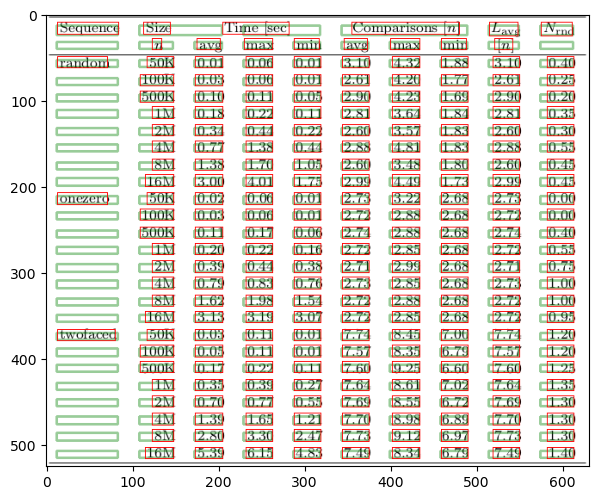

In [13]:
for text, (l, t, r, b) in train_chunk_labels[img_name]:
    cv.rectangle(res, (l, t), (r, b), (255, 0, 0), 1)
view_imgs([res])

In [14]:
len(cells_merged_gt), len(cells_merged_pred)

(256, 256)

Given information:
- List of posistions of ground truth cells (t,l,r,b) in `cells_merged_gt`
- List of positions of predicted cells (t,l,r,b) in `cells_merged_pred`
- List of contents and positions for text (content, (t,l,r,b)) in `texts_pos`

In [15]:
def update_cells_content(cells, texts_pos):
    '''
    Update contents of cells based on positions of texts
    Args:
        cells -- list of Cells
        texts_pos -- contents and positions of texts
    Returns:
        cells -- a deep copy of cells containing texts information
    '''
    cells = copy.deepcopy(cells)
    for cell in cells:
        cell_t, cell_l, cell_b, cell_r = cell.top, cell.left, cell.bottom, cell.right
        for content, (text_l, text_t, text_r, text_b) in texts_pos:
            if (text_l >= cell_l or cell_l - text_l <= 10) and \
                (text_t >= cell_t or cell_t - text_t <= 10) and \
                (text_r <= cell_r or text_r - cell_r <= 10) and \
                (text_b <= cell_b or text_b - cell_b <= 10):
                cell.content = content
    return cells

cells_merged_gt = update_cells_content(cells_merged_gt, texts_pos)
cells_merged_pred = update_cells_content(cells_merged_pred, texts_pos)

In [16]:
RIGHT = 1
DOWN = 2

def find_right_relations(cell, cells_list, processed_cells=set(), root=None, n_steps=0):
    rels = []
    
    # Check if the cell has already been processed
    if cell in processed_cells:
        return rels
    
    processed_cells.add(cell)  # Mark the cell as processed

    right_neighbor_l = min((c.left for c in cells_list if c.left >= cell.right), default=None)
    candidates = [c for c in cells_list 
                  if (c.left == right_neighbor_l and c.top >= cell.top and c.bottom <= cell.bottom)]

    if root is None:
        root = cell 
    for cand in candidates:
        if cand.content is not None:
            rels.append(Relation(root.content, cand.content, RIGHT, n_blanks=n_steps))
        else:
            # Find the right relations of this candidate with empty content
            empty_relations = find_right_relations(cand, cells_list, processed_cells, root, n_steps+1)
            rels.extend(empty_relations)

    return rels

def find_down_relations(cell, cells_list, processed_cells=set(), root=None, n_steps=0):
    rels = []
    
    # Check if the cell has already been processed
    if cell in processed_cells:
        return rels
    
    processed_cells.add(cell)  # Mark the cell as processed

    down_neighbor_t = min((c.top for c in cells_list if c.top >= cell.bottom), default=None)
    candidates = [c for c in cells_list
                  if (c.top == down_neighbor_t and c.left >= cell.left and c.right <= cell.right)]

    if root is None:
        root = cell
    for cand in candidates:
        if cand.content is not None:
            rels.append(Relation(root.content, cand.content, DOWN, n_blanks=n_steps))
        else:
            # Find the down relations of this candidate with empty content
            empty_relations = find_down_relations(cand, cells_list, processed_cells, root, n_steps+1)
            rels.extend(empty_relations)

    return rels

TODO: there is one current error with this two functions, relations found here for this cell won't appear later in the entire list of relations. Could be because of recursion, check again

In [17]:
# find_right_relations(cells_merged_pred[1], cells_merged_pred)

In [18]:
# find_down_relations(cells_merged_pred[1], cells_merged_pred)

In [19]:
def cells2relations(cells_list):
    '''
    Convert cells into relations
    Args:
        cells_list -- list of Cells containing texts information
    Returns:
        rels -- list of Relations
    '''
    rels = []
    for cell in cells_list:
        if cell.content is None:
            continue
        rels.extend(find_right_relations(cell, cells_list))
        rels.extend(find_down_relations(cell, cells_list))
    return rels

In [20]:
rels_gt = cells2relations(cells_merged_gt)
rels_gt

[Relation(Sequence, Size, RIGHT, n_blanks=0),
 Relation(Sequence, random, DOWN, n_blanks=1),
 Relation(Size, Time[sec], RIGHT, n_blanks=0),
 Relation(Size, n, DOWN, n_blanks=0),
 Relation(Time[sec], Comparisons[n], RIGHT, n_blanks=0),
 Relation(Time[sec], avg, DOWN, n_blanks=0),
 Relation(Time[sec], max, DOWN, n_blanks=0),
 Relation(Time[sec], min, DOWN, n_blanks=0),
 Relation(Comparisons[n], L avg, RIGHT, n_blanks=0),
 Relation(Comparisons[n], avg, DOWN, n_blanks=0),
 Relation(Comparisons[n], max, DOWN, n_blanks=0),
 Relation(Comparisons[n], min, DOWN, n_blanks=0),
 Relation(L avg, N rnd, RIGHT, n_blanks=0),
 Relation(L avg, [n], DOWN, n_blanks=0),
 Relation(N rnd, 0.40, DOWN, n_blanks=1),
 Relation(n, avg, RIGHT, n_blanks=0),
 Relation(n, 50K, DOWN, n_blanks=0),
 Relation(avg, max, RIGHT, n_blanks=0),
 Relation(avg, 0.01, DOWN, n_blanks=0),
 Relation(max, min, RIGHT, n_blanks=0),
 Relation(max, 0.06, DOWN, n_blanks=0),
 Relation(min, avg, RIGHT, n_blanks=0),
 Relation(min, 0.01, DOWN

In [21]:
rels_pred = cells2relations(cells_merged_pred)
rels_pred

[Relation(Sequence, Size, RIGHT, n_blanks=0),
 Relation(Sequence, random, DOWN, n_blanks=1),
 Relation(Size, Comparisons[n], RIGHT, n_blanks=1),
 Relation(Size, n, DOWN, n_blanks=0),
 Relation(Size, avg, DOWN, n_blanks=0),
 Relation(Comparisons[n], L avg, RIGHT, n_blanks=0),
 Relation(Comparisons[n], avg, DOWN, n_blanks=0),
 Relation(Comparisons[n], max, DOWN, n_blanks=0),
 Relation(Comparisons[n], min, DOWN, n_blanks=0),
 Relation(L avg, N rnd, RIGHT, n_blanks=0),
 Relation(L avg, [n], DOWN, n_blanks=0),
 Relation(N rnd, 0.40, DOWN, n_blanks=1),
 Relation(n, avg, RIGHT, n_blanks=0),
 Relation(n, 50K, DOWN, n_blanks=0),
 Relation(avg, max, RIGHT, n_blanks=0),
 Relation(avg, 0.01, DOWN, n_blanks=0),
 Relation(max, min, RIGHT, n_blanks=0),
 Relation(max, 0.06, DOWN, n_blanks=0),
 Relation(min, avg, RIGHT, n_blanks=0),
 Relation(min, 0.01, DOWN, n_blanks=0),
 Relation(avg, max, RIGHT, n_blanks=0),
 Relation(avg, 3.10, DOWN, n_blanks=0),
 Relation(max, min, RIGHT, n_blanks=0),
 Relation(ma

In [22]:
def compare_relations(rels_pred, rels_gt, compare_blanks=True):
    '''
    Count the number of correct relation predictions
    Args:
        rels_pred -- list of predicted relations
        rels_gt -- list of ground truth relations
        compare_blanks -- boolean, whether to take the number of blank cells into account
    Returns:
        cnt -- number of correct predicted relations
    '''
    dup_rels_pred = copy.deepcopy(rels_pred)
    cnt = 0
    for rgt in rels_gt:
        to_rm = None
        for i, rp in enumerate(dup_rels_pred):
            if rgt.equal(rp, compare_blanks):
                to_rm = i
                cnt += 1
                break

        if to_rm is not None:
            dup_rels_pred = dup_rels_pred[:i] + dup_rels_pred[i:]

    return cnt

In [23]:
compare_relations(rels_pred, rels_gt), len(rels_pred), len(rels_gt)

(429, 431, 434)

In [24]:
def eval_relations_macro(gt, pred, cmp_blanks=True):
    '''
    Calculate precision, recall, and F1 score at macro level
    Args:
        pred -- a list of lists of Relations from prediction (for all table images where each image contains a list of Relations)
        gt -- a list of lists of Relations from ground truth
    Returns:
        res -- dictionary containing 3 keys: 'prec', 'rec', 'f1'
    '''
    tot_prec, tot_rec, cnt = 0, 0, 0
    assert len(pred) == len(gt)

    for preds, gts in zip(pred, gt):
        n_correct = compare_relations(preds, gts, cmp_blanks)
        prec = n_correct / len(preds) if len(preds) != 0 else 0
        rec = n_correct / len(gts) if len(gts) != 0 else 0
        tot_prec += prec
        tot_rec += rec
        cnt += 1

    precision = tot_prec / cnt if cnt != 0 else 0
    recall = tot_rec / cnt if cnt != 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0

    return {'prec': precision, 'rec': recall, 'f1': f1}

def eval_relations_micro(gt, pred, cmp_blanks=True):
    '''
    Calculate precision, recall, and F1 score at micro level
    Args:
        pred -- a list of lists of Relations from prediction (for all table images where each image contains a list of Relations)
        gt -- a list of lists of Relations from ground truth
    Returns:
        res -- dictionary containing 3 keys: 'prec', 'rec', 'f1'
    '''
    TP, FP, FN = 0, 0, 0

    assert len(pred) == len(gt)

    for preds, gts in zip(pred, gt):
        n_correct = compare_relations(preds, gts, cmp_blanks)
        TP += n_correct
        FP += (len(preds) - n_correct)
        FN += (len(gts) - n_correct)

    # Handle the case when both predicted and ground truth lists are empty
    if TP == 0 and FP == 0 and FN == 0:
        precision, recall, f1 = 0.0, 0.0, 0.0
    else:
        precision = TP / (TP + FP) if (TP + FP) > 0 else 0.0
        recall = TP / (TP + FN) if (TP + FN) > 0 else 0.0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0.0

    return {'prec': precision, 'rec': recall, 'f1': f1}

Putting everything together

In [25]:
def write_list_txt(file_path, string_list):
    """
    Write a list of strings to a text file, with each string on a new line.

    Parameters:
    - file_path (str): The path to the text file.
    - string_list (list): The list of strings to be written to the file.
    """
    try:
        with open(file_path, 'w') as file:
            for string in string_list:
                file.write(str(string) + '\n')
        print(f"Successfully wrote {len(string_list)} lines to {file_path}")
    except Exception as e:
        print(f"Error writing to {file_path}: {e}")

def process_relations(part_dir, error_path=None):
    '''
    Args:
        part_dir -- partitioned directory. Could be 'train', 'val', or 'test'
    Returns:
        gt -- list of list of Relations
        pred -- list of list of Relations
    '''
    RIGHT = 1
    DOWN = 2
    error_names = []

    part_label_dir = os.path.join(part_dir, 'label')
    split_labels = load_json(os.path.join(part_label_dir, 'split_label.json'))
    merge_labels = load_json(os.path.join(part_label_dir, 'merge_label.json'))
    chunk_labels = load_json(os.path.join(part_label_dir, 'chunk_label.json'))

    img_names = list(split_labels.keys())
    gt, pred = [], []
    for img_name in tqdm(img_names, desc='Image'):
        # print(img_name)
        
        # ground truth
        r_gt, c_gt, R_gt, D_gt = load_merge_gt(merge_labels, img_name)
        row_gt_idxs, col_gt_idxs = borders(r_gt), borders(c_gt)
        cells_gt = get_cells(row_gt_idxs, col_gt_idxs)
        cells_merged_gt = merge_cells(cells_gt, R_gt, D_gt, verbose=False)
        if cells_merged_gt is None:
            error_names.append(img_name)
            continue
        
        # prediction
        texts_pos = chunk_labels[img_name]
        R_pred, D_pred = create_pred_matrices(row_gt_idxs, col_gt_idxs)
        rule1(cells_gt, texts_pos, R_pred, D_pred)
        rule2(cells_gt, texts_pos, R_pred, D_pred)
        cells_merged_pred = merge_cells(cells_gt, R_pred, D_pred, verbose=False)
        
        # adjacency relation
        cells_merged_gt = update_cells_content(cells_merged_gt, texts_pos)
        cells_merged_pred = update_cells_content(cells_merged_pred, texts_pos)
        rels_gt = cells2relations(cells_merged_gt)
        rels_pred = cells2relations(cells_merged_pred)
        gt.append(rels_gt)
        pred.append(rels_pred)
        
    print('Finished processing relations')
    if error_path is not None:
        print(f'Found {len(error_names)}/{len(img_names)} images with label error stored at {error_path}')
        write_list_txt(error_path, error_names)
    return gt, pred

In [26]:
gt, pred = process_relations(train_dir, error_path='/Users/longhoang/Developer/table-recognition/error/adj_rel_errors.txt')

Image:   1%|          | 69/10000 [00:00<01:24, 117.86it/s]

ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells


Image:   1%|          | 106/10000 [00:00<01:26, 114.84it/s]

ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells


Image:   1%|▏         | 133/10000 [00:01<01:50, 89.62it/s] 

ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells


Image:   2%|▏         | 171/10000 [00:01<01:47, 91.66it/s]

ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells


Image:   2%|▏         | 193/10000 [00:02<02:31, 64.73it/s]

ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells


Image:   2%|▏         | 222/10000 [00:02<01:52, 86.90it/s]

ERROR: Shape of R and D don't match the number of cells


Image:   3%|▎         | 254/10000 [00:03<02:07, 76.24it/s]

ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells


Image:   3%|▎         | 279/10000 [00:03<01:58, 82.12it/s]

ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells


Image:   3%|▎         | 317/10000 [00:03<01:19, 121.20it/s]

ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells


Image:   3%|▎         | 345/10000 [00:03<01:40, 95.61it/s] 

ERROR: Shape of R and D don't match the number of cells


Image:   4%|▍         | 414/10000 [00:04<01:06, 144.82it/s]

ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells


Image:   5%|▍         | 458/10000 [00:04<00:52, 180.30it/s]

ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells


Image:   5%|▌         | 546/10000 [00:05<01:21, 116.67it/s]

ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells


Image:   6%|▌         | 597/10000 [00:06<01:30, 103.49it/s]

ERROR: Shape of R and D don't match the number of cells


Image:   6%|▌         | 618/10000 [00:06<01:15, 124.12it/s]

ERROR: Shape of R and D don't match the number of cells


Image:   7%|▋         | 664/10000 [00:06<01:23, 111.19it/s]

ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells


Image:   7%|▋         | 699/10000 [00:07<01:37, 95.39it/s] 

ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells


Image:   7%|▋         | 746/10000 [00:08<03:59, 38.60it/s] 

ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells


Image:   8%|▊         | 793/10000 [00:09<02:26, 63.03it/s]

ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells


Image:   8%|▊         | 827/10000 [00:09<01:44, 88.16it/s]

ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells


Image:   9%|▊         | 868/10000 [00:09<01:07, 136.10it/s]

ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells


Image:   9%|▉         | 901/10000 [00:10<01:31, 99.90it/s] 

ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells


Image:   9%|▉         | 929/10000 [00:10<01:34, 95.93it/s]

ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells


Image:  10%|▉         | 969/10000 [00:10<01:10, 127.34it/s]

ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells


Image:  11%|█         | 1072/10000 [00:12<01:29, 99.61it/s]

ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells


Image:  11%|█         | 1096/10000 [00:12<01:13, 120.75it/s]

ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells


Image:  11%|█         | 1118/10000 [00:12<01:34, 94.00it/s] 

ERROR: Shape of R and D don't match the number of cells


Image:  11%|█▏        | 1136/10000 [00:14<03:33, 41.49it/s]

ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells


Image:  12%|█▏        | 1167/10000 [00:15<04:11, 35.15it/s]

ERROR: Shape of R and D don't match the number of cells


Image:  12%|█▏        | 1209/10000 [00:15<02:01, 72.50it/s]

ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells


Image:  13%|█▎        | 1259/10000 [00:17<04:37, 31.55it/s]

ERROR: Shape of R and D don't match the number of cells


Image:  13%|█▎        | 1334/10000 [00:18<01:27, 99.10it/s]

ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells


Image:  14%|█▍        | 1384/10000 [00:19<01:25, 101.13it/s]

ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells


Image:  14%|█▍        | 1398/10000 [00:19<01:34, 91.29it/s] 

ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells


Image:  15%|█▍        | 1463/10000 [00:19<01:02, 137.68it/s]

ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells


Image:  15%|█▍        | 1493/10000 [00:19<01:15, 112.25it/s]

ERROR: Shape of R and D don't match the number of cells


Image:  15%|█▌        | 1547/10000 [00:20<00:56, 149.82it/s]

ERROR: Shape of R and D don't match the number of cells


Image:  16%|█▌        | 1606/10000 [00:20<00:52, 159.08it/s]

ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells


Image:  16%|█▌        | 1624/10000 [00:22<03:53, 35.92it/s] 

ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells


Image:  17%|█▋        | 1698/10000 [00:22<01:31, 90.91it/s]

ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells


Image:  17%|█▋        | 1735/10000 [00:23<01:20, 102.52it/s]

ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells


Image:  18%|█▊        | 1766/10000 [00:23<01:23, 98.87it/s] 

ERROR: Shape of R and D don't match the number of cells


Image:  18%|█▊        | 1822/10000 [00:23<00:59, 136.76it/s]

ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells


Image:  19%|█▊        | 1858/10000 [00:23<00:54, 148.76it/s]

ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells


Image:  19%|█▉        | 1937/10000 [00:24<00:55, 145.56it/s]

ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells


Image:  20%|█▉        | 1984/10000 [00:25<01:27, 91.78it/s] 

ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells


Image:  20%|██        | 2010/10000 [00:25<01:28, 89.91it/s]

ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells


Image:  20%|██        | 2043/10000 [00:25<01:09, 113.99it/s]

ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells


Image:  21%|██        | 2091/10000 [00:26<01:36, 82.02it/s] 

ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells


Image:  21%|██        | 2122/10000 [00:26<01:29, 88.41it/s]

ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells


Image:  21%|██▏       | 2140/10000 [00:27<01:14, 105.42it/s]

ERROR: Shape of R and D don't match the number of cells


Image:  22%|██▏       | 2172/10000 [00:27<01:33, 83.29it/s] 

ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells


Image:  22%|██▏       | 2227/10000 [00:27<01:05, 117.94it/s]

ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells


Image:  23%|██▎       | 2272/10000 [00:28<01:11, 107.57it/s]

ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells


Image:  23%|██▎       | 2320/10000 [00:29<02:05, 61.30it/s] 

ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells


Image:  24%|██▎       | 2374/10000 [00:29<01:14, 101.76it/s]

ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells


Image:  25%|██▍       | 2477/10000 [00:30<00:38, 192.90it/s]

ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells


Image:  25%|██▌       | 2528/10000 [00:30<00:34, 216.06it/s]

ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells


Image:  26%|██▌       | 2606/10000 [00:31<00:41, 176.85it/s]

ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells


Image:  27%|██▋       | 2667/10000 [00:31<00:43, 169.69it/s]

ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells


Image:  27%|██▋       | 2748/10000 [00:32<00:42, 170.41it/s]

ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells


Image:  28%|██▊       | 2830/10000 [00:32<00:36, 197.11it/s]

ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells


Image:  29%|██▉       | 2895/10000 [00:32<00:36, 195.96it/s]

ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells


Image:  29%|██▉       | 2940/10000 [00:33<00:54, 130.13it/s]

ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells


Image:  30%|███       | 3010/10000 [00:33<00:55, 125.27it/s]

ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells


Image:  31%|███       | 3072/10000 [00:34<00:52, 132.12it/s]

ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells


Image:  31%|███▏      | 3139/10000 [00:34<00:45, 150.47it/s]

ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells


Image:  32%|███▏      | 3174/10000 [00:35<00:58, 117.29it/s]

ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells


Image:  32%|███▏      | 3228/10000 [00:35<00:49, 137.45it/s]

ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells


Image:  33%|███▎      | 3280/10000 [00:35<00:35, 189.50it/s]

ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells


Image:  33%|███▎      | 3340/10000 [00:36<00:40, 162.98it/s]

ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells


Image:  34%|███▍      | 3376/10000 [00:36<00:41, 161.29it/s]

ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells


Image:  34%|███▍      | 3394/10000 [00:36<00:49, 134.22it/s]

ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells


Image:  36%|███▌      | 3588/10000 [00:39<00:53, 119.51it/s]

ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells


Image:  36%|███▌      | 3606/10000 [00:39<00:50, 127.15it/s]

ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells


Image:  36%|███▌      | 3623/10000 [00:40<00:57, 111.03it/s]

ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells


Image:  37%|███▋      | 3692/10000 [00:41<01:23, 75.96it/s] 

ERROR: Shape of R and D don't match the number of cells


Image:  37%|███▋      | 3713/10000 [00:41<01:20, 77.77it/s]

ERROR: Shape of R and D don't match the number of cells


Image:  38%|███▊      | 3752/10000 [00:42<01:14, 83.68it/s]

ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells


Image:  38%|███▊      | 3786/10000 [00:42<01:01, 101.67it/s]

ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells


Image:  38%|███▊      | 3833/10000 [00:43<01:36, 63.85it/s] 

ERROR: Shape of R and D don't match the number of cells


Image:  39%|███▊      | 3871/10000 [00:43<01:09, 88.67it/s]

ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells


Image:  39%|███▉      | 3936/10000 [00:44<00:48, 124.00it/s]

ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells


Image:  40%|███▉      | 3990/10000 [00:44<00:32, 183.93it/s]

ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells


Image:  40%|████      | 4038/10000 [00:44<00:34, 175.35it/s]

ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells


Image:  41%|████      | 4075/10000 [00:45<00:39, 148.64it/s]

ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells


Image:  41%|████▏     | 4125/10000 [00:45<00:54, 107.81it/s]

ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells


Image:  42%|████▏     | 4224/10000 [00:46<00:33, 174.37it/s]

ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells


Image:  43%|████▎     | 4274/10000 [00:46<00:37, 151.78it/s]

ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells


Image:  43%|████▎     | 4322/10000 [00:46<00:29, 190.64it/s]

ERROR: Shape of R and D don't match the number of cells


Image:  44%|████▍     | 4382/10000 [00:47<00:38, 147.51it/s]

ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells


Image:  45%|████▍     | 4451/10000 [00:47<00:29, 186.20it/s]

ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells


Image:  45%|████▌     | 4517/10000 [00:47<00:28, 190.89it/s]

ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells


Image:  46%|████▌     | 4581/10000 [00:48<00:30, 178.38it/s]

ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells


Image:  46%|████▋     | 4638/10000 [00:48<00:24, 222.22it/s]

ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells


Image:  47%|████▋     | 4701/10000 [00:48<00:30, 172.20it/s]

ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells


Image:  47%|████▋     | 4737/10000 [00:49<00:32, 164.18it/s]

ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells


Image:  48%|████▊     | 4795/10000 [00:49<00:30, 172.05it/s]

ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells


Image:  48%|████▊     | 4832/10000 [00:49<00:32, 160.21it/s]

ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells


Image:  48%|████▊     | 4849/10000 [00:49<00:35, 145.15it/s]

ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells


Image:  49%|████▉     | 4925/10000 [00:50<00:42, 119.54it/s]

ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells


Image:  50%|████▉     | 4969/10000 [00:51<00:33, 150.14it/s]

ERROR: Shape of R and D don't match the number of cells


Image:  50%|█████     | 5021/10000 [00:51<00:41, 120.24it/s]

ERROR: Shape of R and D don't match the number of cells


Image:  51%|█████     | 5079/10000 [00:52<00:34, 141.60it/s]

ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells


Image:  51%|█████     | 5112/10000 [00:52<00:35, 139.54it/s]

ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells


Image:  52%|█████▏    | 5173/10000 [00:52<00:28, 169.71it/s]

ERROR: Shape of R and D don't match the number of cells


Image:  52%|█████▏    | 5191/10000 [00:52<00:30, 157.15it/s]

ERROR: Shape of R and D don't match the number of cells


Image:  53%|█████▎    | 5264/10000 [00:53<00:27, 171.46it/s]

ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells


Image:  53%|█████▎    | 5309/10000 [00:53<00:24, 195.32it/s]

ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells


Image:  54%|█████▍    | 5388/10000 [00:53<00:23, 200.50it/s]

ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells


Image:  55%|█████▍    | 5459/10000 [00:54<00:21, 207.26it/s]

ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells


Image:  55%|█████▍    | 5481/10000 [00:54<00:23, 192.75it/s]

ERROR: Shape of R and D don't match the number of cells


Image:  55%|█████▌    | 5537/10000 [00:54<00:31, 139.72it/s]

ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells


Image:  56%|█████▌    | 5585/10000 [00:55<00:36, 119.88it/s]

ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells


Image:  56%|█████▌    | 5612/10000 [00:55<00:41, 104.59it/s]

ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells


Image:  57%|█████▋    | 5672/10000 [00:56<00:30, 140.19it/s]

ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells


Image:  57%|█████▋    | 5726/10000 [00:56<00:35, 120.61it/s]

ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells


Image:  58%|█████▊    | 5785/10000 [00:56<00:30, 139.05it/s]

ERROR: Shape of R and D don't match the number of cells


Image:  59%|█████▊    | 5874/10000 [00:57<00:24, 165.97it/s]

ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells


Image:  59%|█████▉    | 5918/10000 [00:57<00:23, 170.44it/s]

ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells


Image:  60%|█████▉    | 5951/10000 [00:58<00:32, 123.31it/s]

ERROR: Shape of R and D don't match the number of cells


Image:  60%|██████    | 6025/10000 [00:58<00:26, 152.28it/s]

ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells


Image:  61%|██████    | 6092/10000 [00:58<00:23, 168.69it/s]

ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells


Image:  62%|██████▏   | 6159/10000 [00:59<00:19, 192.52it/s]

ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells


Image:  62%|██████▏   | 6232/10000 [00:59<00:17, 218.35it/s]

ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells


Image:  63%|██████▎   | 6255/10000 [00:59<00:23, 161.77it/s]

ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells


Image:  63%|██████▎   | 6305/10000 [01:00<00:18, 197.52it/s]

ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells


Image:  64%|██████▎   | 6363/10000 [01:02<01:24, 43.08it/s] 

ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells


Image:  64%|██████▍   | 6433/10000 [01:03<00:39, 90.88it/s]

ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells


Image:  65%|██████▍   | 6477/10000 [01:03<00:29, 118.32it/s]

ERROR: Shape of R and D don't match the number of cells


Image:  66%|██████▌   | 6552/10000 [01:04<00:22, 153.59it/s]

ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells


Image:  66%|██████▋   | 6625/10000 [01:04<00:16, 210.05it/s]

ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells


Image:  67%|██████▋   | 6680/10000 [01:04<00:14, 228.35it/s]

ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells


Image:  68%|██████▊   | 6751/10000 [01:05<00:17, 187.01it/s]

ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells


Image:  68%|██████▊   | 6834/10000 [01:05<00:14, 217.01it/s]

ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells


Image:  69%|██████▉   | 6896/10000 [01:05<00:18, 165.44it/s]

ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells


Image:  70%|██████▉   | 6960/10000 [01:06<00:16, 184.56it/s]

ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells


Image:  70%|███████   | 7001/10000 [01:06<00:16, 179.51it/s]

ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells


Image:  71%|███████   | 7103/10000 [01:06<00:12, 240.86it/s]

ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells


Image:  72%|███████▏  | 7155/10000 [01:07<00:13, 207.63it/s]

ERROR: Shape of R and D don't match the number of cells


Image:  72%|███████▏  | 7177/10000 [01:07<00:22, 125.16it/s]

ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells


Image:  72%|███████▏  | 7245/10000 [01:08<00:19, 138.28it/s]

ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells


Image:  73%|███████▎  | 7289/10000 [01:08<00:15, 170.34it/s]

ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells


Image:  74%|███████▎  | 7362/10000 [01:08<00:12, 207.21it/s]

ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells


Image:  74%|███████▍  | 7435/10000 [01:08<00:12, 208.65it/s]

ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells


Image:  75%|███████▍  | 7494/10000 [01:09<00:10, 246.06it/s]

ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells


Image:  76%|███████▌  | 7550/10000 [01:09<00:10, 224.69it/s]

ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells


Image:  76%|███████▋  | 7630/10000 [01:09<00:10, 234.60it/s]

ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells


Image:  77%|███████▋  | 7706/10000 [01:10<00:11, 203.39it/s]

ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells


Image:  78%|███████▊  | 7750/10000 [01:10<00:11, 198.02it/s]

ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells


Image:  78%|███████▊  | 7848/10000 [01:10<00:10, 204.23it/s]

ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells


Image:  79%|███████▉  | 7892/10000 [01:11<00:11, 184.75it/s]

ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells


Image:  80%|███████▉  | 7970/10000 [01:11<00:09, 205.03it/s]

ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells


Image:  81%|████████  | 8058/10000 [01:13<00:22, 84.45it/s] 

ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells


Image:  81%|████████  | 8099/10000 [01:13<00:17, 108.51it/s]

ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells


Image:  81%|████████  | 8117/10000 [01:13<00:20, 91.93it/s] 

ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells


Image:  82%|████████▏ | 8217/10000 [01:14<00:12, 147.40it/s]

ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells


Image:  82%|████████▏ | 8235/10000 [01:14<00:11, 147.30it/s]

ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells


Image:  83%|████████▎ | 8266/10000 [01:15<00:15, 112.95it/s]

ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells


Image:  83%|████████▎ | 8325/10000 [01:15<00:10, 162.81it/s]

ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells


Image:  84%|████████▎ | 8370/10000 [01:15<00:09, 165.13it/s]

ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells


Image:  84%|████████▍ | 8410/10000 [01:15<00:11, 139.54it/s]

ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells


Image:  85%|████████▍ | 8460/10000 [01:16<00:08, 180.05it/s]

ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells


Image:  85%|████████▍ | 8480/10000 [01:16<00:08, 176.50it/s]

ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells


Image:  85%|████████▌ | 8519/10000 [01:16<00:11, 132.78it/s]

ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells


Image:  85%|████████▌ | 8549/10000 [01:16<00:11, 126.28it/s]

ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells


Image:  86%|████████▌ | 8577/10000 [01:17<00:13, 108.83it/s]

ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells


Image:  87%|████████▋ | 8667/10000 [01:17<00:07, 184.88it/s]

ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells


Image:  87%|████████▋ | 8714/10000 [01:17<00:06, 208.34it/s]

ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells


Image:  88%|████████▊ | 8777/10000 [01:18<00:07, 173.49it/s]

ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells


Image:  89%|████████▉ | 8880/10000 [01:18<00:04, 232.23it/s]

ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells


Image:  89%|████████▉ | 8904/10000 [01:18<00:05, 198.77it/s]

ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells


Image:  90%|████████▉ | 8970/10000 [01:19<00:07, 138.20it/s]

ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells


Image:  90%|█████████ | 9015/10000 [01:19<00:06, 159.73it/s]

ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells


Image:  91%|█████████ | 9052/10000 [01:20<00:06, 146.94it/s]

ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells


Image:  91%|█████████ | 9100/10000 [01:20<00:07, 118.64it/s]

ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells


Image:  92%|█████████▏| 9183/10000 [01:21<00:06, 131.92it/s]

ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells


Image:  92%|█████████▏| 9237/10000 [01:21<00:04, 181.18it/s]

ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells


Image:  93%|█████████▎| 9322/10000 [01:22<00:04, 163.98it/s]

ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells


Image:  93%|█████████▎| 9341/10000 [01:22<00:05, 121.03it/s]

ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells


Image:  94%|█████████▍| 9395/10000 [01:22<00:03, 175.55it/s]

ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells


Image:  94%|█████████▍| 9442/10000 [01:23<00:03, 175.43it/s]

ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells


Image:  95%|█████████▍| 9491/10000 [01:23<00:03, 130.36it/s]

ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells


Image:  95%|█████████▌| 9531/10000 [01:23<00:03, 133.70it/s]

ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells


Image:  96%|█████████▌| 9607/10000 [01:24<00:02, 147.06it/s]

ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells


Image:  96%|█████████▋| 9649/10000 [01:24<00:02, 160.18it/s]

ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells


Image:  97%|█████████▋| 9741/10000 [01:25<00:01, 223.63it/s]

ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells


Image:  98%|█████████▊| 9819/10000 [01:25<00:00, 241.94it/s]

ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells


Image:  98%|█████████▊| 9844/10000 [01:25<00:00, 166.38it/s]

ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells


Image:  99%|█████████▉| 9882/10000 [01:26<00:00, 135.66it/s]

ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells


Image: 100%|█████████▉| 9995/10000 [01:30<00:00, 32.73it/s] 

ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells


Image: 100%|██████████| 10000/10000 [01:30<00:00, 110.77it/s]


Finished processing relations
Found 931/10000 images with label error stored at /Users/longhoang/Developer/table-recognition/error/adj_rel_errors.txt
Successfully wrote 931 lines to /Users/longhoang/Developer/table-recognition/error/adj_rel_errors.txt


In [27]:
res_macro = eval_relations_macro(gt, pred)
res_macro['prec'], res_macro['rec'], res_macro['f1']

(0.9949456103030967, 0.985045506336018, 0.9899708076886743)

In [28]:
res_micro = eval_relations_micro(gt, pred)
res_micro['prec'], res_micro['rec'], res_micro['f1']

(0.994642494736041, 0.984162718458787, 0.9893748560866288)

In [29]:
val_gt, val_pred = process_relations(val_dir, error_path='/Users/longhoang/Developer/table-recognition/error/adj_rel_errors.txt')

Image:   2%|▏         | 44/1971 [00:00<00:14, 134.42it/s]

ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells


Image:   4%|▎         | 70/1971 [00:00<00:17, 110.61it/s]

ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells


Image:   6%|▌         | 117/1971 [00:01<00:23, 80.56it/s]

ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells


Image:  10%|█         | 204/1971 [00:03<00:23, 74.26it/s]

ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells


Image:  12%|█▏        | 231/1971 [00:03<00:19, 89.29it/s]

ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells


Image:  13%|█▎        | 256/1971 [00:03<00:18, 92.81it/s]

ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells


Image:  15%|█▍        | 288/1971 [00:04<00:14, 118.76it/s]

ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells


Image:  16%|█▌        | 308/1971 [00:04<00:13, 125.36it/s]

ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells


Image:  18%|█▊        | 362/1971 [00:04<00:13, 122.85it/s]

ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells


Image:  21%|██        | 409/1971 [00:05<00:13, 115.61it/s]

ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells


Image:  23%|██▎       | 459/1971 [00:05<00:11, 128.15it/s]

ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells


Image:  24%|██▍       | 474/1971 [00:05<00:12, 122.14it/s]

ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells


Image:  28%|██▊       | 559/1971 [00:06<00:10, 131.71it/s]

ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells


Image:  32%|███▏      | 633/1971 [00:06<00:07, 184.56it/s]

ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells


Image:  35%|███▌      | 696/1971 [00:07<00:07, 179.13it/s]

ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells


Image:  38%|███▊      | 758/1971 [00:07<00:08, 150.37it/s]

ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells


Image:  40%|████      | 793/1971 [00:08<00:13, 86.28it/s] 

ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells


Image:  42%|████▏     | 836/1971 [00:08<00:11, 95.46it/s]

ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells


Image:  46%|████▌     | 898/1971 [00:09<00:07, 152.54it/s]

ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells


Image:  47%|████▋     | 935/1971 [00:09<00:06, 153.94it/s]

ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells


Image:  49%|████▉     | 967/1971 [00:09<00:07, 125.60it/s]

ERROR: Shape of R and D don't match the number of cells


Image:  52%|█████▏    | 1029/1971 [00:10<00:06, 149.85it/s]

ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells


Image:  55%|█████▍    | 1080/1971 [00:10<00:04, 192.11it/s]

ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells


Image:  58%|█████▊    | 1142/1971 [00:10<00:04, 182.64it/s]

ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells


Image:  60%|█████▉    | 1181/1971 [00:10<00:04, 167.27it/s]

ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells


Image:  64%|██████▍   | 1262/1971 [00:11<00:04, 176.15it/s]

ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells


Image:  68%|██████▊   | 1332/1971 [00:11<00:03, 192.49it/s]

ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells


Image:  70%|███████   | 1380/1971 [00:11<00:02, 205.63it/s]

ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells


Image:  73%|███████▎  | 1444/1971 [00:12<00:03, 157.00it/s]

ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells


Image:  75%|███████▌  | 1482/1971 [00:12<00:02, 164.00it/s]

ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells


Image:  79%|███████▊  | 1549/1971 [00:12<00:02, 187.14it/s]

ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells


Image:  81%|████████  | 1590/1971 [00:13<00:02, 128.13it/s]

ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells


Image:  83%|████████▎ | 1634/1971 [00:13<00:02, 115.72it/s]

ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells


Image:  86%|████████▋ | 1704/1971 [00:14<00:01, 144.21it/s]

ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells


Image:  91%|█████████ | 1794/1971 [00:14<00:00, 181.16it/s]

ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells


Image:  92%|█████████▏| 1815/1971 [00:14<00:00, 177.44it/s]

ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells


Image:  95%|█████████▌| 1881/1971 [00:15<00:00, 118.24it/s]

ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells


Image: 100%|██████████| 1971/1971 [00:16<00:00, 121.03it/s]

ERROR: Shape of R and D don't match the number of cells
Finished processing relations
Found 201/1971 images with label error stored at /Users/longhoang/Developer/table-recognition/error/adj_rel_errors.txt
Successfully wrote 201 lines to /Users/longhoang/Developer/table-recognition/error/adj_rel_errors.txt


In [30]:
val_res_macro = eval_relations_macro(val_gt, val_pred)
val_res_macro['prec'], val_res_macro['rec'], val_res_macro['f1']

(0.9942425081561685, 0.9859930768236815, 0.9901006094037746)

In [31]:
val_res_micro = eval_relations_micro(val_gt, val_pred)
val_res_micro['prec'], val_res_micro['rec'], val_res_micro['f1']

(0.9941098309918494, 0.9853125401516125, 0.989691636351904)